In [1]:
import json, h5py, os, shutil, sys
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image


import tensorflow as tf
from tensorflow import saved_model
from tensorflow.keras import backend, applications, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework import ops

from SimilarityConfigParser import SimilarityConfigParser

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [3]:
checkpoint_dir = os.path.join('runtime_files', 'saved_model')
checkpoint_auto_dir = os.path.join('runtime_files', 'auto_saved_model.h5')
tensorboard_log_dir = os.path.join('runtime_files', 'logs', str(time()))

config = SimilarityConfigParser()

# Importing the data

In [4]:
argN = 64
train_folder = config.get_train_data_folder()
test_folder = config.get_test_data_folder()

train_dir_anchor = os.path.join(train_folder, 'train_a')
train_dir_positive = os.path.join(train_folder, 'train_p')
train_dir_negative = os.path.join(train_folder, 'train_n')

valid_dir_anchor = os.path.join(train_folder, 'valid_a')
valid_dir_positive = os.path.join(train_folder, 'valid_p')
valid_dir_negative = os.path.join(train_folder, 'valid_n')

test_dir_anchor = os.path.join(test_folder, 'test_a')
test_dir_positive = os.path.join(test_folder, 'test_p')
test_dir_negative = os.path.join(test_folder, 'test_n')

In [5]:
def train_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = train_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = train_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = train_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def valid_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = valid_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = valid_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = valid_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def test_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = test_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = test_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = test_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

# Loss & metric functions

In [6]:
def triplet_loss(N = argN, epsilon = 1e-6):
    def triplet_loss(y_true, y_pred):
        beta = N
        print(y_pred.get_shape())

        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        negative = y_pred[2::3]

        positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis = 0, keepdims = True)
        negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis = 0, keepdims = True)

        positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
        negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)

        loss = negative_distance + positive_distance
        return loss
    return triplet_loss

In [7]:
def pd(N = argN, epsilon = 1e-6):
    def pd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis=0)
        positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
        return backend.mean(positive_distance)
    return pd

def nd(N = argN, epsilon = 1e-06):
    def nd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        negative = y_pred[2::3]
        negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis=0)
        negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)
        return backend.mean(negative_distance)
    return nd

# Defining the model

In [8]:
def make_model():
    input_a = Input(shape = (224, 224, 3),  name = 'input_a')
    input_p = Input(shape = (224, 224, 3),  name = 'input_p')
    input_n = Input(shape = (224, 224, 3),  name = 'input_n')

    base_model = applications.VGG16(include_top = False, weights = 'imagenet')

    l1_a = base_model.layers[0](input_a)
    l1_p = base_model.layers[0](input_p)
    l1_n = base_model.layers[0](input_n)

    l2_a = base_model.layers[1](l1_a)
    l2_p = base_model.layers[1](l1_p)
    l2_n = base_model.layers[1](l1_n)

    l3_a = base_model.layers[2](l2_a)
    l3_p = base_model.layers[2](l2_p)
    l3_n = base_model.layers[2](l2_n)

    l4_a = base_model.layers[3](l3_a)
    l4_p = base_model.layers[3](l3_p)
    l4_n = base_model.layers[3](l3_n)

    l5_a = base_model.layers[4](l4_a)
    l5_p = base_model.layers[4](l4_p)
    l5_n = base_model.layers[4](l4_n)

    l6_a = base_model.layers[5](l5_a)
    l6_p = base_model.layers[5](l5_p)
    l6_n = base_model.layers[5](l5_n)

    l7_a = base_model.layers[6](l6_a)
    l7_p = base_model.layers[6](l6_p)
    l7_n = base_model.layers[6](l6_n)

    l8_a = base_model.layers[7](l7_a)
    l8_p = base_model.layers[7](l7_p)
    l8_n = base_model.layers[7](l7_n)

    l9_a = base_model.layers[8](l8_a)
    l9_p = base_model.layers[8](l8_p)
    l9_n = base_model.layers[8](l8_n)

    lt1 = Dense(64, activation = 'sigmoid')
    lt2 = Dropout(0.5)
    lt3 = Dense(8, activation = 'sigmoid')

    lt1_a = lt1(l9_a)
    lt1_p = lt1(l9_p)
    lt1_n = lt1(l9_n)

    lt2_a = lt2(lt1_a)
    lt2_p = lt2(lt1_p)
    lt2_n = lt2(lt1_n)

    lt3_a = lt3(lt2_a)
    lt3_p = lt3(lt2_p)
    lt3_n = lt3(lt2_n)

    output = tf.keras.layers.concatenate([lt3_a, lt3_p, lt3_n], axis = 0, name = 'out666')
    model = tf.keras.models.Model(inputs = [input_a, input_p, input_n], outputs = output)

    for layer in model.layers:
        if layer.name == 'dense':
            break
        layer.trainable = False

    model.compile(optimizer = optimizers.Adam(), loss = triplet_loss(), metrics = [pd(), nd()])

    return model

# Training

In [9]:
def train_model():
    model = make_model()

    cb_tensorboard = TensorBoard(log_dir = tensorboard_log_dir, histogram_freq = 2, write_graph = True, write_images = True)
    cb_checkpoint = ModelCheckpoint(checkpoint_auto_dir, save_weights_only = False, period = 100, verbose = 1)

    model.fit_generator(generator = train_generator_triplet(), steps_per_epoch = argN, epochs = args.epochs, validation_data = valid_generator_triplet(), validation_steps = 3, callbacks = [cb_tensorboard, cb_checkpoint])
    model.save(checkpoint_dir, save_format='tf')

def test_model():
    test_samples = len(os.listdir(os.path.join(test_dir_anchor, "0")))
    model = tf.keras.models.load_model(checkpoint_dir, compile=False)
    model.compile(optimizer = optimizers.Adam(), loss = triplet_loss(), metrics = [pd(), nd()])

    results = model.predict_generator(generator = test_generator_triplet(), steps = test_samples, verbose = 0)

    beta = argN
    epsilon = 1e-6

    anchor = results[0::3]
    positive = results[1::3]
    negative = results[2::3]

    positive_distance = np.nansum(np.square(anchor - positive), axis = 1)
    positive_distance = - np.log(- (positive_distance / beta) + 1 + epsilon)

    negative_distance = np.nansum(np.square(anchor - negative), axis = 1)
    negative_distance = - np.log(- (negative_distance / beta) + 1 + epsilon)

    tp = 0
    fp = 0
    pneq = 0
    min_p = sys.maxsize
    max_p = 0
    min_n = sys.maxsize
    max_n = 0

    for i in range(test_samples):
        pda = np.nansum(positive_distance[i])
        nda = np.nansum(negative_distance[i])
        print(pda, "\t", nda)
    if pda >= nda:
        fp += 1
    else:
        tp += 1
    if pda == nda:
        pneq += 1

    if min_p > pda:
        min_p = pda
    if max_p < pda:
        max_p = pda

    if min_n > nda:
        min_n = nda
    if max_n < nda:
        max_n = nda

    print(min_p, ' - ', max_p, ', ', min_n, ' - ', max_n)
    print('accuracy: ', np.round(tp / (tp + fp) * 100, 1))
    print('equal predictions: ', pneq)


In [10]:
def plot_metrics(history, metrics=['loss'], skip_start=0.):
    """
    Plots metrics from keras training history.
    """
    hist = history.history
    start_indice = int(len(hist[metrics[0]]) * skip_start)
    
    for metric in metrics:
        plt.plot(hist[metric][start_indice:], label="train {}".format(metric))
        plt.plot(hist[f"val_{metric}"][start_indice:], label=f"val {metric}")
        plt.legend()
        plt.title(metric)
        plt.figure()
    
    plt.show()

Training loop

Setting up the callbacks. Added 2 additional callbacks for training:
  - `EarlyStopping` - stops the model once it's no longer getting better at validation data
  - `ReduceLROnPlateau` - reduces learning rate when model doesn't improve on the validation data for some period

In [11]:
callbacks = [
#     TensorBoard(log_dir = tensorboard_log_dir, histogram_freq = 2, write_graph = True, write_images = True),
#     ModelCheckpoint(checkpoint_auto_dir, save_weights_only = False, period = 100, verbose = 1),
    EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
]

In [12]:
model = make_model()

history = model.fit_generator(
    generator = train_generator_triplet(), 
    steps_per_epoch = 1252, 
    epochs = 100, 
    validation_data = valid_generator_triplet(), 
    validation_steps = 100, 
    callbacks = callbacks
)

(None, 56, 56, 8)
Found 1188 images belonging to 1 classes.
Found 1188 images belonging to 1 classes.
Found 1188 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Train for 1252 steps, validate for 100 steps
Epoch 1/100
(None, 56, 56, 8)
(None, 56, 56, 8)
1252/1252 [==============================] - 20s 16ms/step - loss: 6.9644 - pd: 0.0033 - nd: 6.9611 - val_loss: 7.6871 - val_pd: 0.0013 - val_nd: 7.6858
Epoch 2/100
1252/1252 [==============================] - 18s 14ms/step - loss: 6.4194 - pd: 0.0036 - nd: 6.4157 - val_loss: 4.9548 - val_pd: 0.0023 - val_nd: 4.9525
Epoch 3/100
1252/1252 [==============================] - 18s 15ms/step - loss: 4.9180 - pd: 0.0019 - nd: 4.9162 - val_loss: 4.6281 - val_pd: 0.0027 - val_nd: 4.6254
Epoch 4/100
1252/1252 [==============================] - 18s 15ms/step - loss: 4.6843 - pd: 0.0017 - nd: 4.6825 - val_loss: 4.5798 - val_pd: 0.0020 - val_nd:

1252/1252 [==============================] - 18s 15ms/step - loss: 4.4982 - pd: 0.0023 - nd: 4.4959 - val_loss: 4.3585 - val_pd: 0.0030 - val_nd: 4.3555
Epoch 40/100
1252/1252 [==============================] - 18s 15ms/step - loss: 4.4963 - pd: 0.0023 - nd: 4.4940 - val_loss: 4.3658 - val_pd: 0.0028 - val_nd: 4.3631
Epoch 41/100
1249/1252 [============================>.] - ETA: 0s - loss: 4.4962 - pd: 0.0023 - nd: 4.4939
Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
1252/1252 [==============================] - 18s 15ms/step - loss: 4.4959 - pd: 0.0023 - nd: 4.4936 - val_loss: 4.3643 - val_pd: 0.0028 - val_nd: 4.3615
Epoch 42/100
1252/1252 [==============================] - 18s 15ms/step - loss: 4.5017 - pd: 0.0022 - nd: 4.4995 - val_loss: 4.3630 - val_pd: 0.0028 - val_nd: 4.3602
Epoch 43/100
1252/1252 [==============================] - 18s 15ms/step - loss: 4.5098 - pd: 0.0023 - nd: 4.5076 - val_loss: 4.3668 - val_pd: 0.0027 - val_nd: 4.3641
Epoch 44

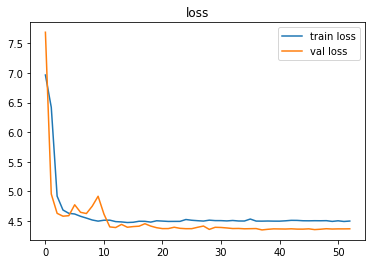

<Figure size 432x288 with 0 Axes>

In [13]:
plot_metrics(history, metrics=['loss',], skip_start=0.0)

`test_model` function not fixed yet

In [ ]:
test_model()   